In [1]:
!pip install -q deepod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmetrics 1.8.2 requires torch>=2.0.0, but you have torch 1.13.0 which is incompatible.
pytorch-lightning 2.5.5 requires torch>=2.1.0, but you have torch 1.13.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 1.13.0 which is incompatible.
torchdata 0.11.0 requires torch>=2, but you have torch 1.13.0 w

In [2]:
# Dataset URL: kaggle.com/datasets/hoanggvo/computational-finance/versions/2

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.preprocessing import StandardScaler
from deepod.models.time_series import TimesNet

# Hiển thị đồ thị đẹp hơn
plt.rcParams["figure.dpi"] = 120

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [4]:
CSV_PATH = "/kaggle/input/computational-finance/yfinance/per_symbol/AACG.csv"


def load_price_series(csv_path: str) -> pd.DataFrame:
    """Load 1 file csv yfinance và chuẩn hóa index thời gian."""

    df_raw = pd.read_csv(csv_path)

    # Nếu dòng đầu là header lỗi kiểu "ATLO" thì bỏ
    first_ts = pd.to_datetime(df_raw.loc[0, "Date"], errors="coerce")
    if pd.isna(first_ts):
        df_raw = df_raw.iloc[1:].reset_index(drop=True)

    df = df_raw.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()

    # Các cột giá cơ bản
    float_cols = ["Close", "High", "Low", "Open", "Adj Close", "Volume"]
    float_cols = [c for c in float_cols if c in df.columns]

    # Chuyển sang numeric, xử lý NaN
    df[float_cols] = df[float_cols].apply(pd.to_numeric, errors="coerce")
    df = df.dropna(subset=["Close"])
    df[float_cols] = df[float_cols].ffill().bfill()

    # Cắt outlier volume một chút cho đỡ lệch
    if "Volume" in df.columns:
        v = df["Volume"]
        upper = v.quantile(0.999)
        df["Volume"] = v.clip(upper=upper)

    return df, float_cols


df_price, base_cols = load_price_series(CSV_PATH)
print(df_price.head())
print("Number of rows:", len(df_price))
print("Base columns:", base_cols)


               Close      High       Low      Open   Volume Symbol  \
Date                                                                 
2015-11-09  0.402813  0.417199  0.388427  0.407609  12400.0   AACG   
2015-11-10  0.394181  0.401854  0.394181  0.397059  10700.0   AACG   
2015-11-11  0.399936  0.406649  0.395140  0.395140  45000.0   AACG   
2015-11-12  0.405690  0.420077  0.391304  0.399936  26400.0   AACG   
2015-11-13  0.415281  0.426790  0.402813  0.405690  18700.0   AACG   

                                                Security Name  
Date                                                           
2015-11-09  ATA Creativity Global - American Depositary Sh...  
2015-11-10  ATA Creativity Global - American Depositary Sh...  
2015-11-11  ATA Creativity Global - American Depositary Sh...  
2015-11-12  ATA Creativity Global - American Depositary Sh...  
2015-11-13  ATA Creativity Global - American Depositary Sh...  
Number of rows: 2513
Base columns: ['Close', 'High', 'Low', '

In [5]:
def build_feature_matrix(df_price: pd.DataFrame, base_cols: list):
    """Tạo ma trận feature X cho TimesNet."""

    feat = df_price[base_cols].copy()

    # Log1p volume cho cân bằng
    if "Volume" in feat.columns:
        feat["Volume"] = np.log1p(feat["Volume"])

    # Log return của Close
    if "Close" in feat.columns:
        feat["LogRet_Close"] = np.log(feat["Close"]).diff().fillna(0.0)

    # Có thể thêm các feature khác ở đây nếu muốn
    feat = feat.astype("float32")

    scaler = StandardScaler()
    X = scaler.fit_transform(feat.values).astype("float32")

    return feat, X, scaler


df_feat, X_all, scaler = build_feature_matrix(df_price, base_cols)
print("Feature shape:", X_all.shape)
df_feat.head()


Feature shape: (2513, 6)


Close      High       Low      Open     Volume  LogRet_Close
Date                                                                       
2015-11-09  0.402813  0.417199  0.388427  0.407609   9.425532      0.000000
2015-11-10  0.394181  0.401854  0.394181  0.397059   9.278092     -0.021661
2015-11-11  0.399936  0.406649  0.395140  0.395140  10.714440      0.014493
2015-11-12  0.405690  0.420077  0.391304  0.399936  10.181157      0.014286
2015-11-13  0.415281  0.426790  0.402813  0.405690   9.836332      0.023366

In [6]:
# Map window size sang số ngày giao dịch xấp xỉ
WINDOW_CONFIGS = {
    "1d": 1,
    "1w": 5,
    "1m": 21,
    "3m": 21 * 3,
    "1y": 252,
    "3y": 252 * 3,
    "5y": 252 * 5,
}


WINDOW_ORDER = ["1d", "1w", "1m", "3m", "1y", "3y", "5y"]
MIN_SEQ_LEN = 16

EPOCHS = 20          # có thể tăng nếu thời gian cho phép
BATCH_SIZE = 128
LR = 1e-4
EPOCH_STEPS = 20    # giữ mặc định TimesNet theo docs :contentReference[oaicite:1]{index=1}


def train_timesnet_for_window(
    X: np.ndarray,
    seq_len_days: int,
    device: str = DEVICE,
    epochs: int = EPOCHS,
    batch_size: int = BATCH_SIZE,
    lr: float = LR,
    epoch_steps: int = EPOCH_STEPS,
    verbose: int = 1,
    random_state: int = 42,
):
    """Train TimesNet cho 1 window size."""

    actual_seq_len = max(seq_len_days, MIN_SEQ_LEN)

    print(f"  Using seq_len = {actual_seq_len} (from {seq_len_days} days)")

    clf = TimesNet(
        seq_len=actual_seq_len,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
        epoch_steps=epoch_steps,
        prt_steps=1,
        device=device,
        verbose=verbose,
        random_state=random_state,
    )

    clf.fit(X)

    scores = clf.decision_function(X)
    labels = clf.predict(X)

    return {
        "model": clf,
        "scores": scores,
        "labels": labels,
        "seq_len": actual_seq_len,
    }


In [7]:
results = {}

for name in WINDOW_ORDER:
    n_days = WINDOW_CONFIGS[name]
    print(f"\nTraining TimesNet for window {name} (target {n_days} days)...")
    res = train_timesnet_for_window(
        X_all,
        seq_len_days=n_days,
    )
    results[name] = res

print("\nDone training all windows.")



Training TimesNet for window 1d (target 1 days)...
  Using seq_len = 16 (from 1 days)
epoch  1, training loss: 0.364343, time: 5.7s
epoch  2, training loss: 0.289368, time: 4.5s
epoch  3, training loss: 0.246757, time: 4.5s
epoch  4, training loss: 0.204503, time: 4.5s
epoch  5, training loss: 0.170463, time: 4.5s
epoch  6, training loss: 0.119903, time: 4.5s
epoch  7, training loss: 0.113743, time: 4.5s
epoch  8, training loss: 0.101990, time: 4.5s
epoch  9, training loss: 0.112946, time: 4.5s
epoch 10, training loss: 0.083724, time: 4.5s
epoch 11, training loss: 0.080272, time: 4.5s
epoch 12, training loss: 0.070798, time: 4.5s
epoch 13, training loss: 0.071517, time: 4.5s
epoch 14, training loss: 0.069657, time: 4.5s
epoch 15, training loss: 0.069068, time: 4.5s
epoch 16, training loss: 0.067294, time: 4.5s
epoch 17, training loss: 0.063642, time: 4.5s
epoch 18, training loss: 0.063491, time: 4.5s
epoch 19, training loss: 0.062671, time: 4.5s
epoch 20, training loss: 0.061300, time

In [8]:
df_results = {}

for name in WINDOW_ORDER:
    res = results[name]
    df_tmp = df_price.copy()
    df_tmp[f"score_{name}"] = res["scores"]
    df_tmp[f"label_{name}"] = res["labels"]
    df_results[name] = df_tmp

# Thử xem một mẫu
df_results["1m"].head()


Close      High       Low      Open   Volume Symbol  \
Date                                                                 
2015-11-09  0.402813  0.417199  0.388427  0.407609  12400.0   AACG   
2015-11-10  0.394181  0.401854  0.394181  0.397059  10700.0   AACG   
2015-11-11  0.399936  0.406649  0.395140  0.395140  45000.0   AACG   
2015-11-12  0.405690  0.420077  0.391304  0.399936  26400.0   AACG   
2015-11-13  0.415281  0.426790  0.402813  0.405690  18700.0   AACG   

                                                Security Name  score_1m  \
Date                                                                      
2015-11-09  ATA Creativity Global - American Depositary Sh...       0.0   
2015-11-10  ATA Creativity Global - American Depositary Sh...       0.0   
2015-11-11  ATA Creativity Global - American Depositary Sh...       0.0   
2015-11-12  ATA Creativity Global - American Depositary Sh...       0.0   
2015-11-13  ATA Creativity Global - American Depositary Sh...       0.0   

            label_1m  
Date                  
2015-11-09         0  
2015-11-10         0  
2015-11-11         0  
2015-11-12         0  
2015-11-13         0

In [9]:
def plot_price_with_anomalies(
    df: pd.DataFrame,
    price_col: str,
    label_col: str,
    title: str,
):
    fig, ax = plt.subplots(figsize=(16, 4))

    # Giá
    ax.plot(df.index, df[price_col], linewidth=0.8, label="Close")

    # Điểm anomaly
    mask_anom = df[label_col] == 1
    ax.scatter(
        df.index[mask_anom],
        df.loc[mask_anom, price_col],
        s=12,
        color="red",
        alpha=0.8,
        label="Anomaly",
    )

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_col)
    ax.legend()
    ax.grid(alpha=0.2)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


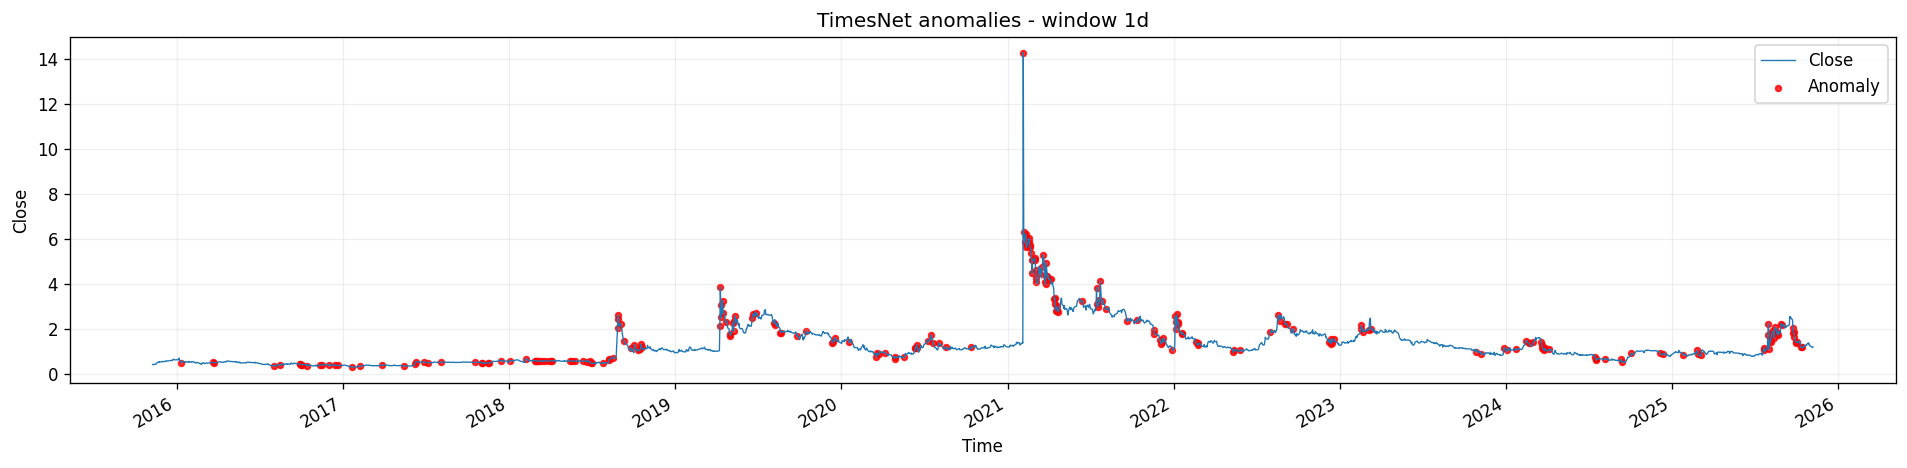

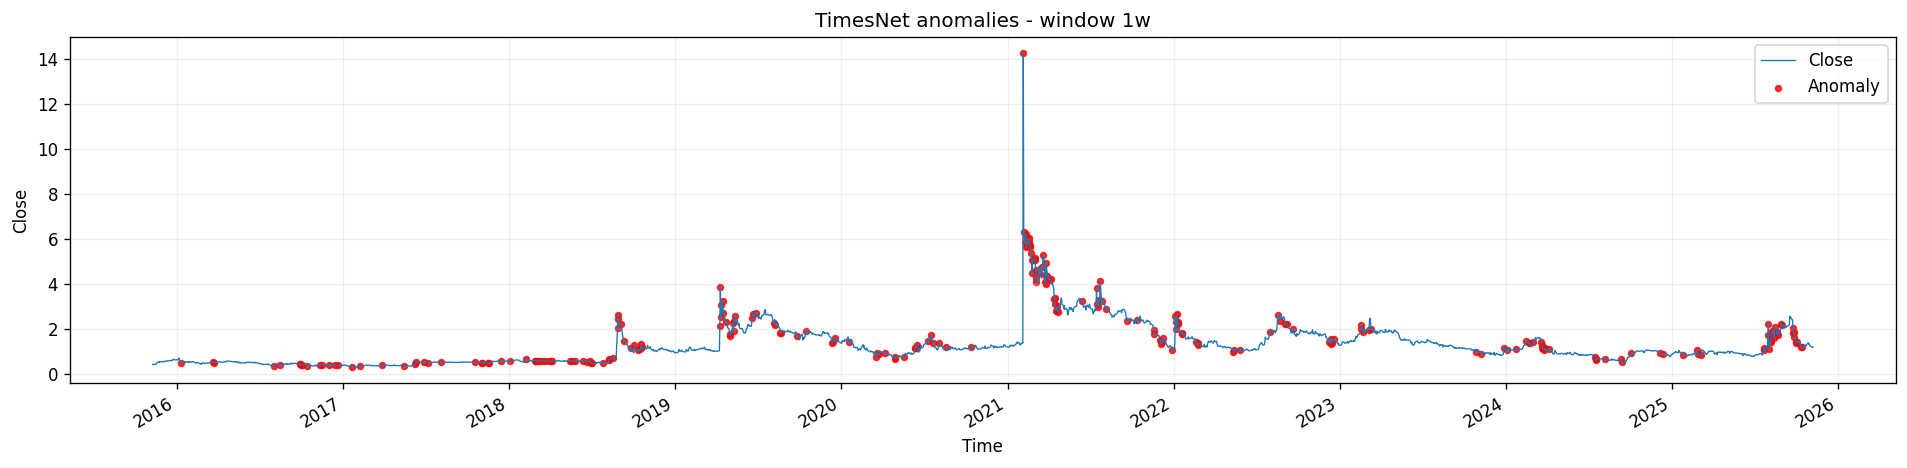

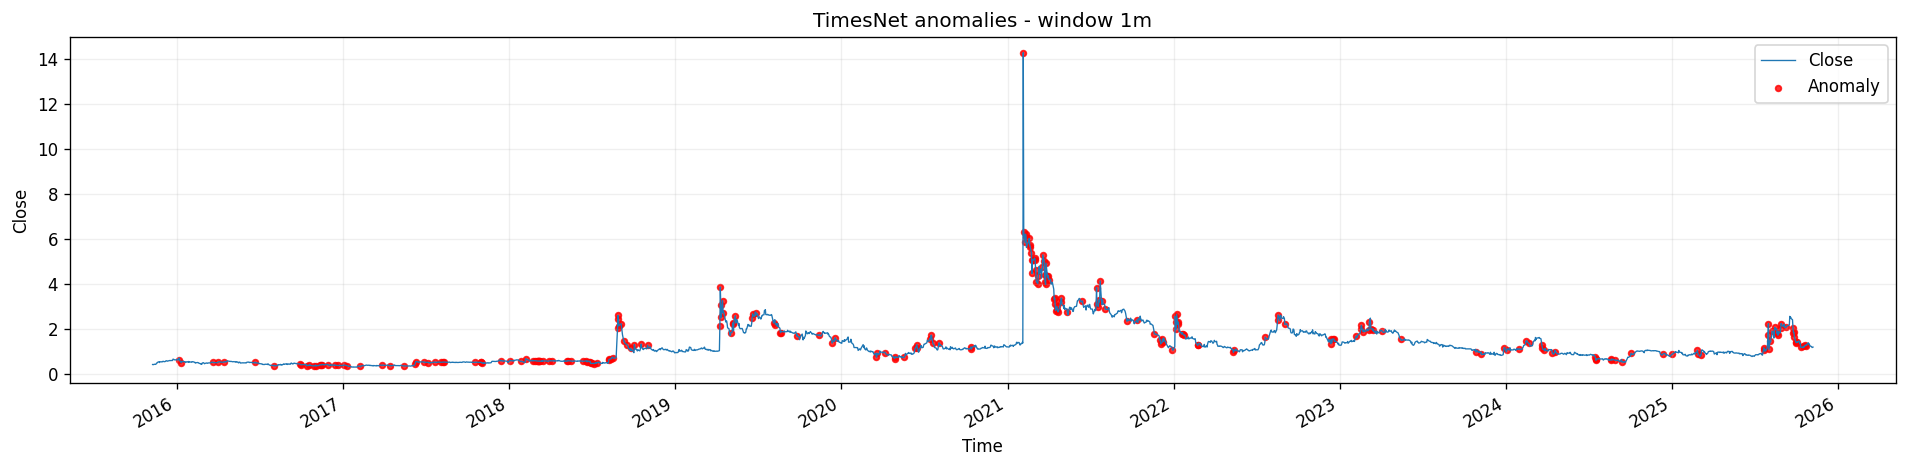

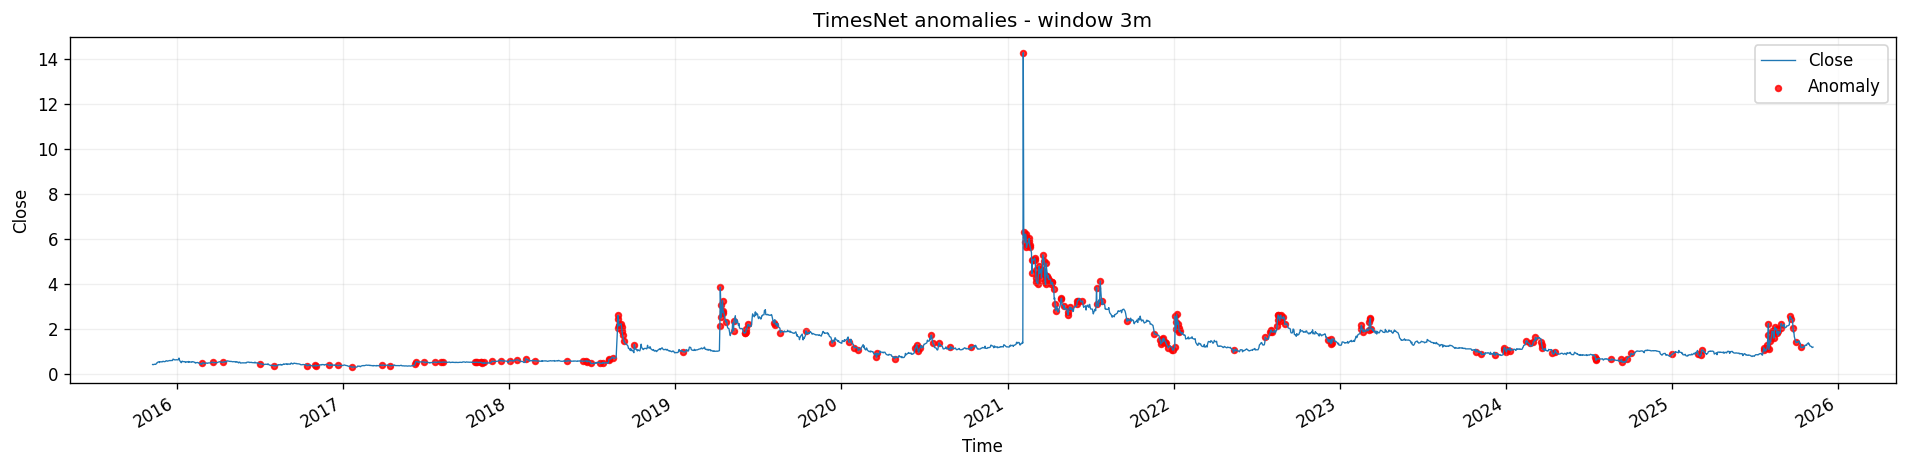

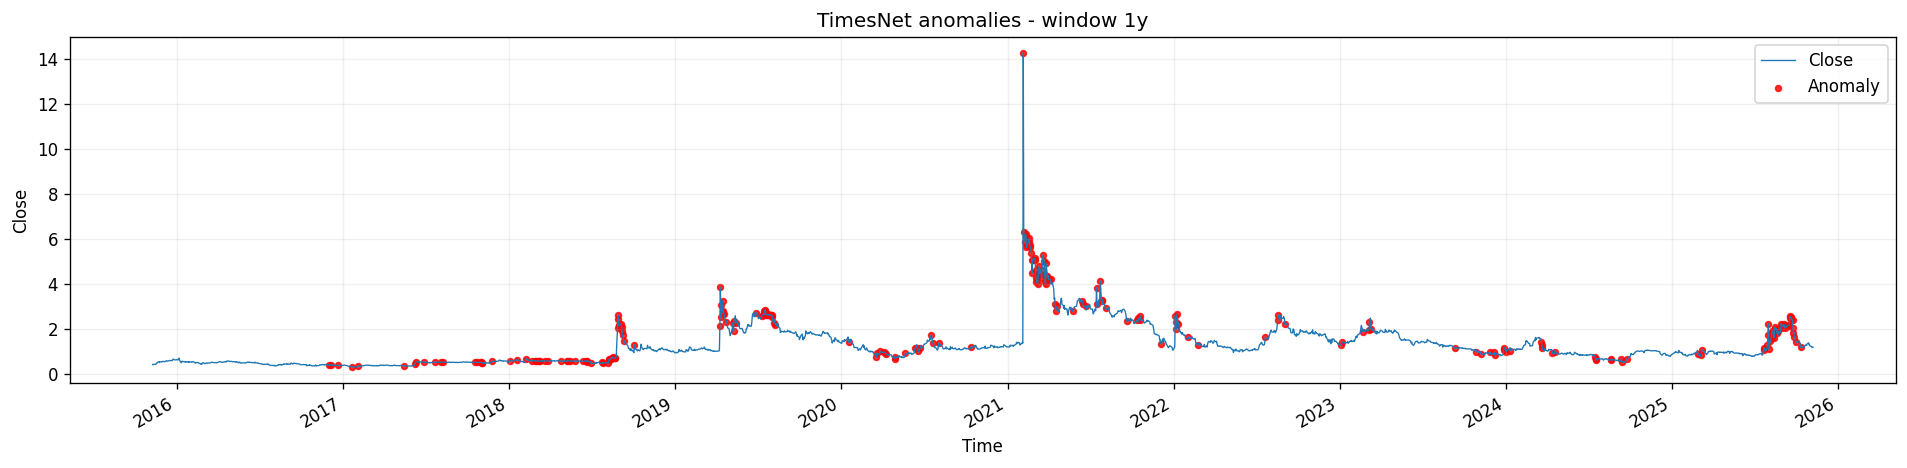

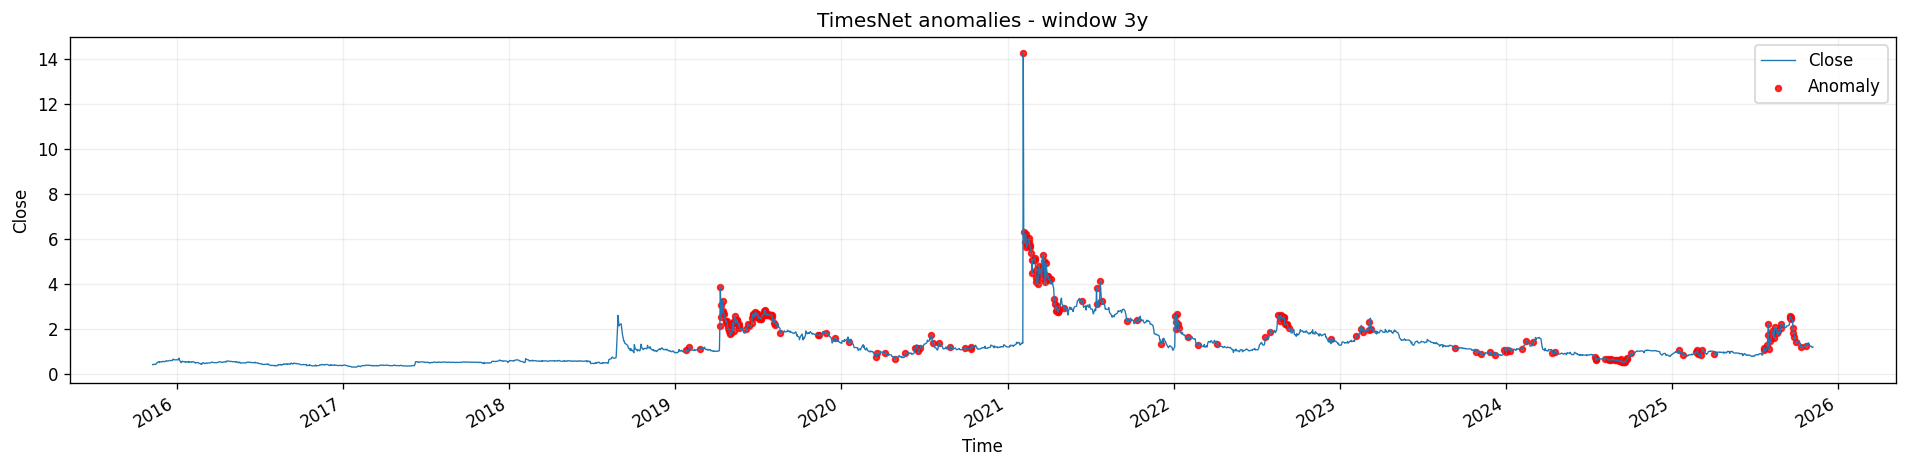

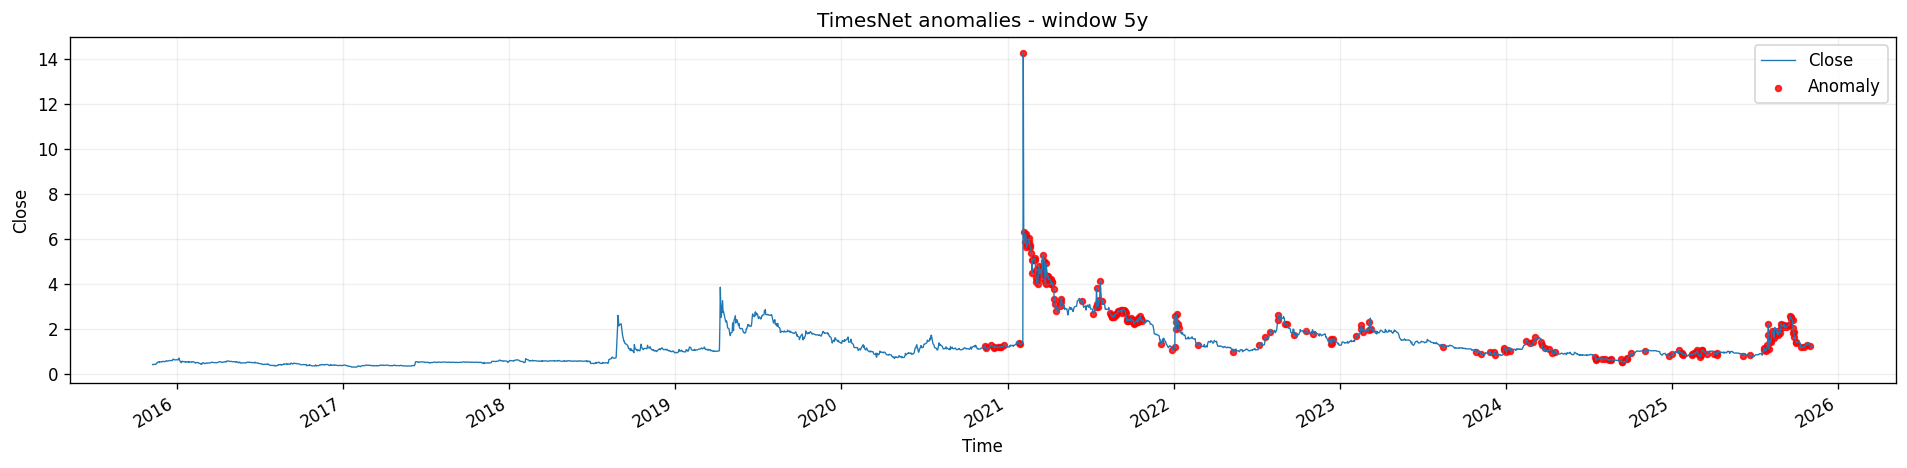

In [10]:
for name in WINDOW_ORDER:
    df_plot = df_results[name]
    plot_price_with_anomalies(
        df_plot,
        price_col="Close",
        label_col=f"label_{name}",
        title=f"TimesNet anomalies - window {name}",
    )


In [11]:
def plot_compare_windows_grid(
    df_results: dict,
    window_order=WINDOW_ORDER,
    price_col: str = "Close",
    years_per_chunk: int = 2,
):
    """
    Vẽ so sánh anomaly giữa các window, nhưng chia dữ liệu thành các đoạn theo năm.
    
    Mỗi figure tương ứng với một đoạn thời gian dài years_per_chunk năm.
    Trong mỗi figure, bố cục vẫn là 1 cột, mỗi hàng là 1 window.
    """

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    if not window_order:
        print("window_order rỗng, không có gì để vẽ.")
        return

    # Lấy index thời gian làm chuẩn từ window đầu tiên
    ref_df = df_results[window_order[0]]
    if not isinstance(ref_df.index, pd.DatetimeIndex):
        raise ValueError("Index của df_results phải là DatetimeIndex.")

    start_date = ref_df.index.min().normalize()
    end_date = ref_df.index.max().normalize()

    if pd.isna(start_date) or pd.isna(end_date):
        print("Không tìm được khoảng thời gian hợp lệ để vẽ.")
        return

    # Tạo danh sách các khoảng thời gian [chunk_start, chunk_end)
    chunks = []
    cur_start = start_date

    while cur_start < end_date:
        cur_end = cur_start + pd.DateOffset(years=years_per_chunk)
        chunks.append((cur_start, cur_end))
        cur_start = cur_end

    print(f"Tổng số đoạn thời gian: {len(chunks)} (mỗi đoạn {years_per_chunk} năm)")

    # Vẽ cho từng chunk
    for chunk_idx, (chunk_start, chunk_end) in enumerate(chunks, start=1):
        # Giới hạn chunk_end không vượt quá end_date
        chunk_end_effective = min(chunk_end, end_date + pd.Timedelta(days=1))

        n_rows = len(window_order)
        fig, axes = plt.subplots(
            n_rows,
            1,
            figsize=(16, 3 * n_rows),
            sharex=True,
        )

        # Trường hợp chỉ có 1 window thì axes là 1 object
        if n_rows == 1:
            axes = [axes]

        has_any_data = False

        for ax, name in zip(axes, window_order):
            df_full = df_results[name]

            # Lọc dữ liệu trong khoảng thời gian của chunk
            mask = (df_full.index >= chunk_start) & (df_full.index < chunk_end_effective)
            df = df_full.loc[mask]

            if df.empty:
                ax.text(
                    0.5,
                    0.5,
                    "No data in this range",
                    ha="center",
                    va="center",
                    transform=ax.transAxes,
                )
                ax.set_title(f"Window {name} (no data)")
                ax.grid(alpha=0.2)
                continue

            has_any_data = True

            label_col = f"label_{name}"

            # Vẽ đường giá
            ax.plot(df.index, df[price_col], linewidth=0.8, label="Close")

            # Vẽ anomaly
            if label_col in df.columns:
                mask_anom = df[label_col] == 1
                if mask_anom.any():
                    ax.scatter(
                        df.index[mask_anom],
                        df.loc[mask_anom, price_col],
                        s=10,
                        color="red",
                        alpha=0.7,
                        label="Anomaly",
                    )

            seq_len_used = results[name]["seq_len"]
            ax.set_title(
                f"Window {name} (seq_len={seq_len_used})"
            )
            ax.grid(alpha=0.2)
            ax.legend(loc="upper left")

        if not has_any_data:
            plt.close(fig)
            continue

        axes[-1].set_xlabel(
            f"Time from {chunk_start.date()} to {chunk_end_effective.date()}"
        )
        fig.suptitle(
            f"TimesNet anomalies by window size, chunk {chunk_idx}: "
            f"{chunk_start.date()} to {chunk_end_effective.date()}",
            y=1.02,
            fontsize=12,
        )

        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()


Tổng số đoạn thời gian: 5 (mỗi đoạn 2 năm)


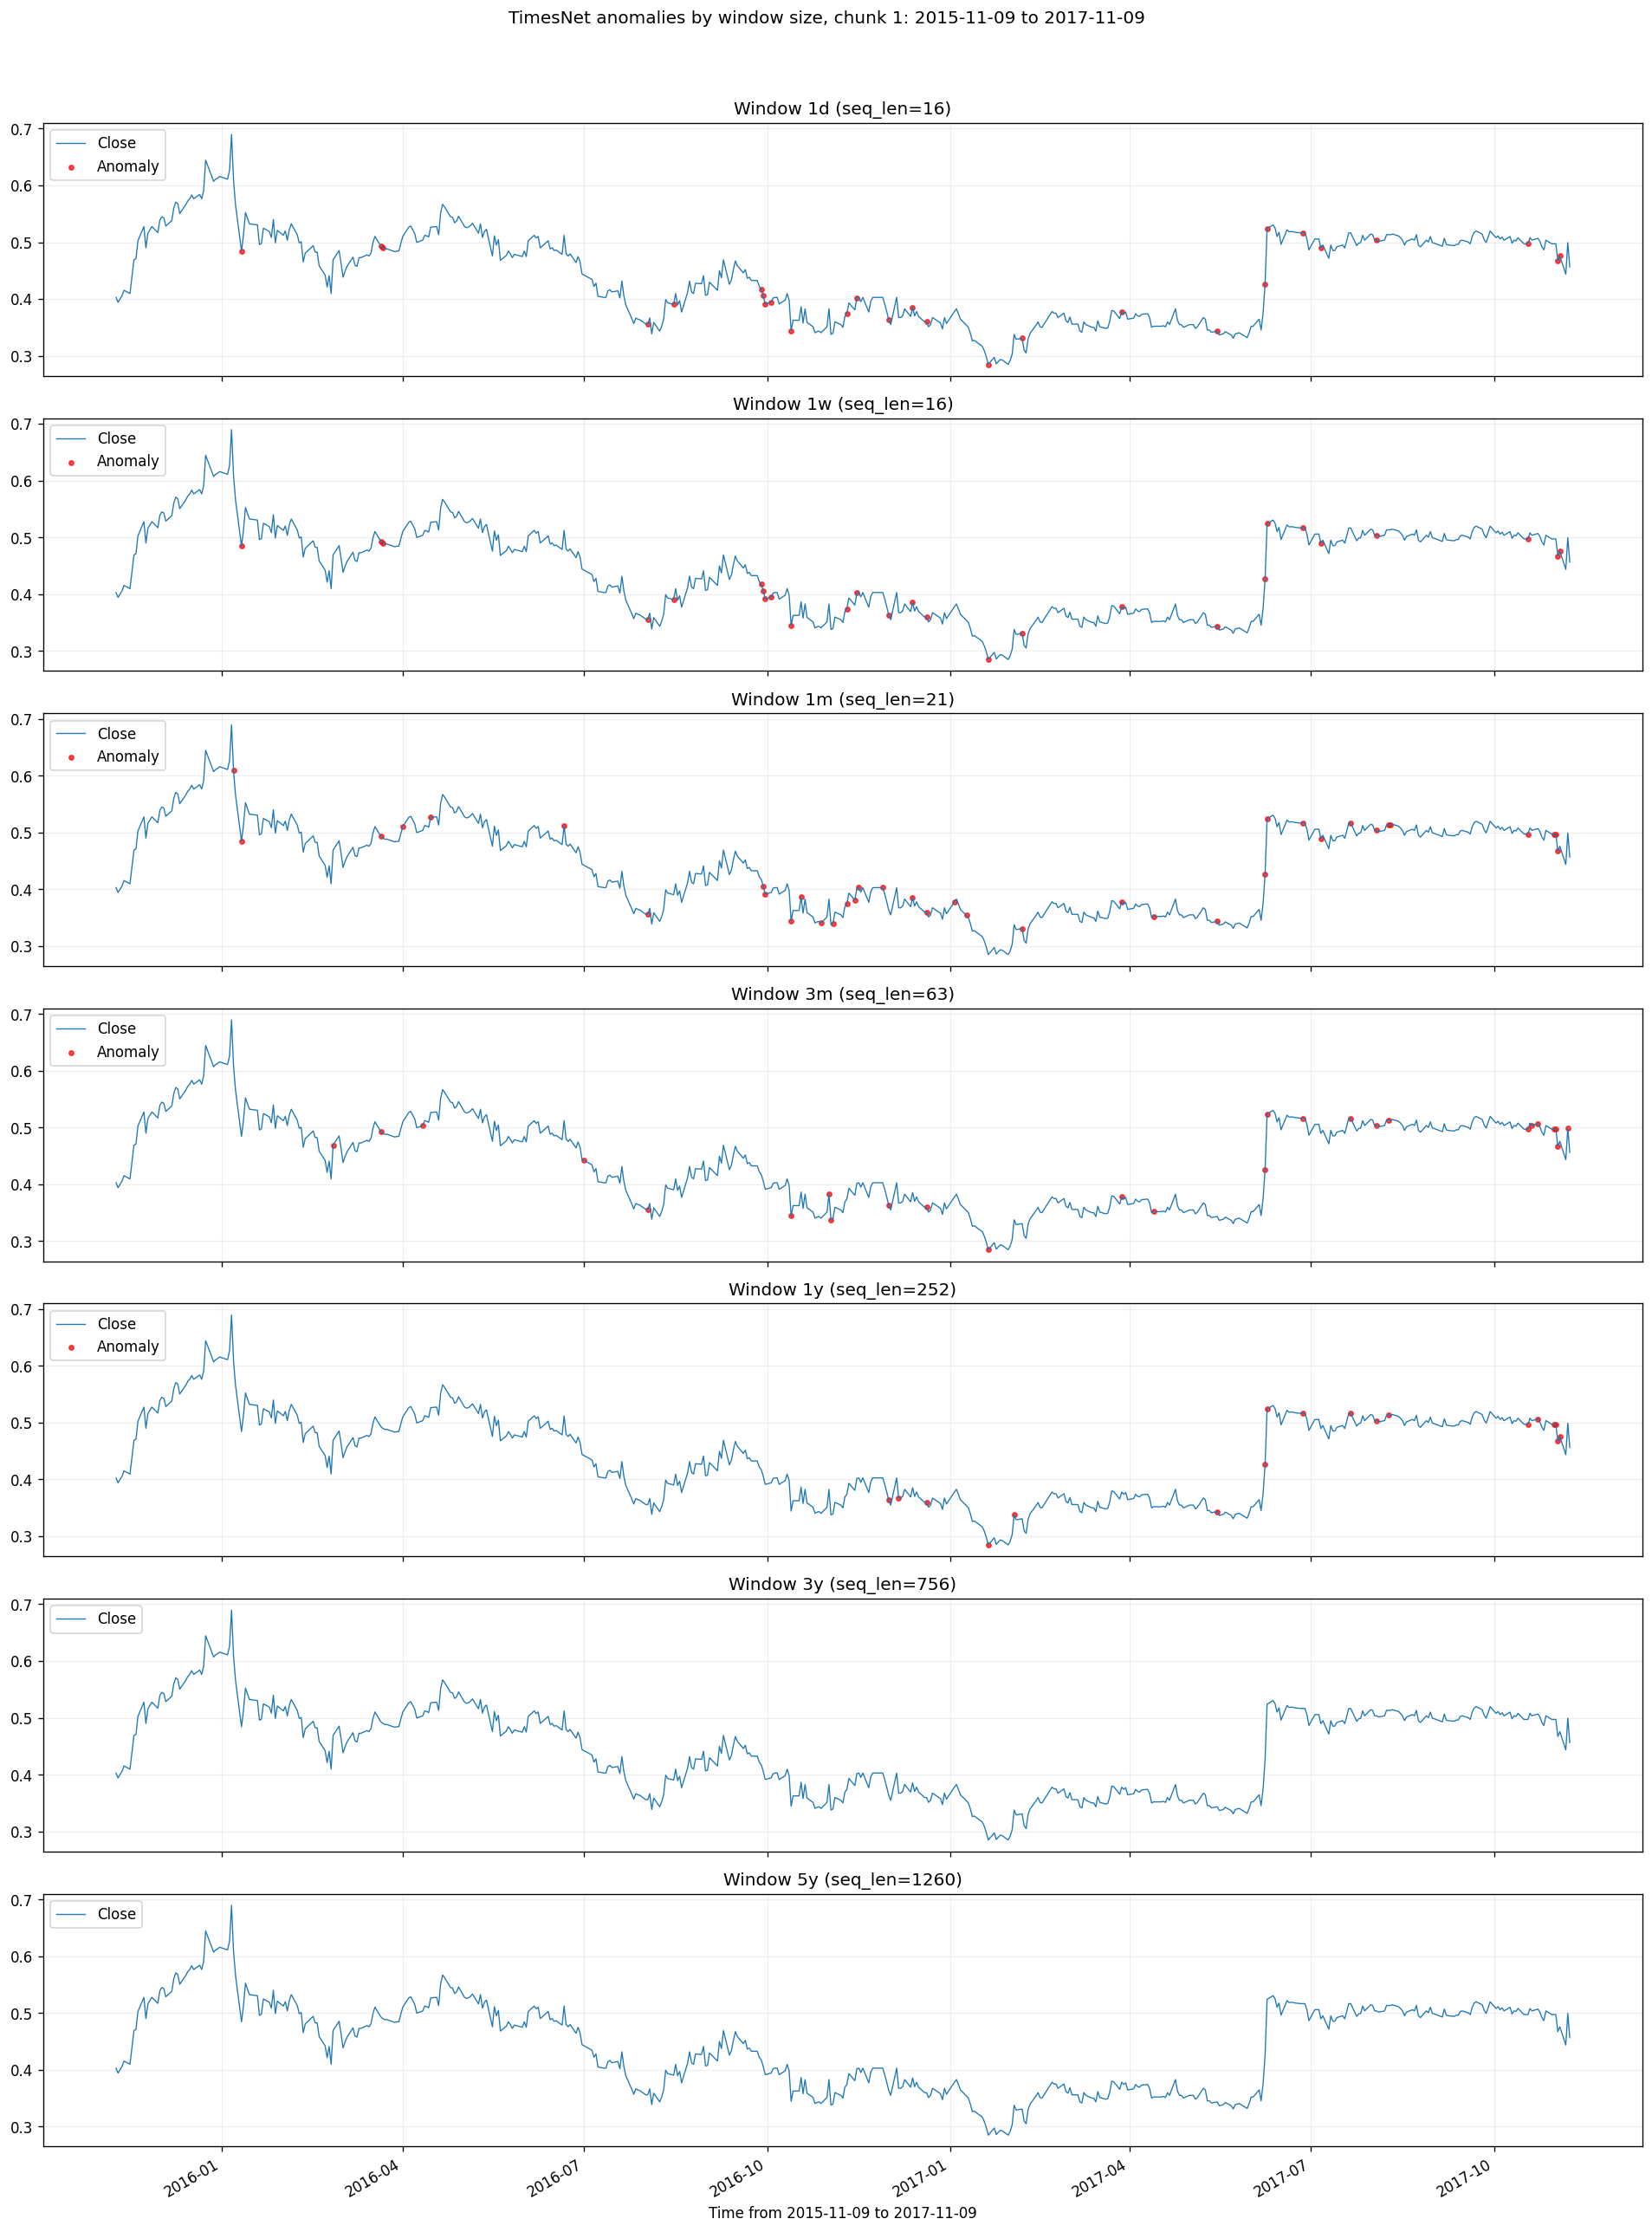

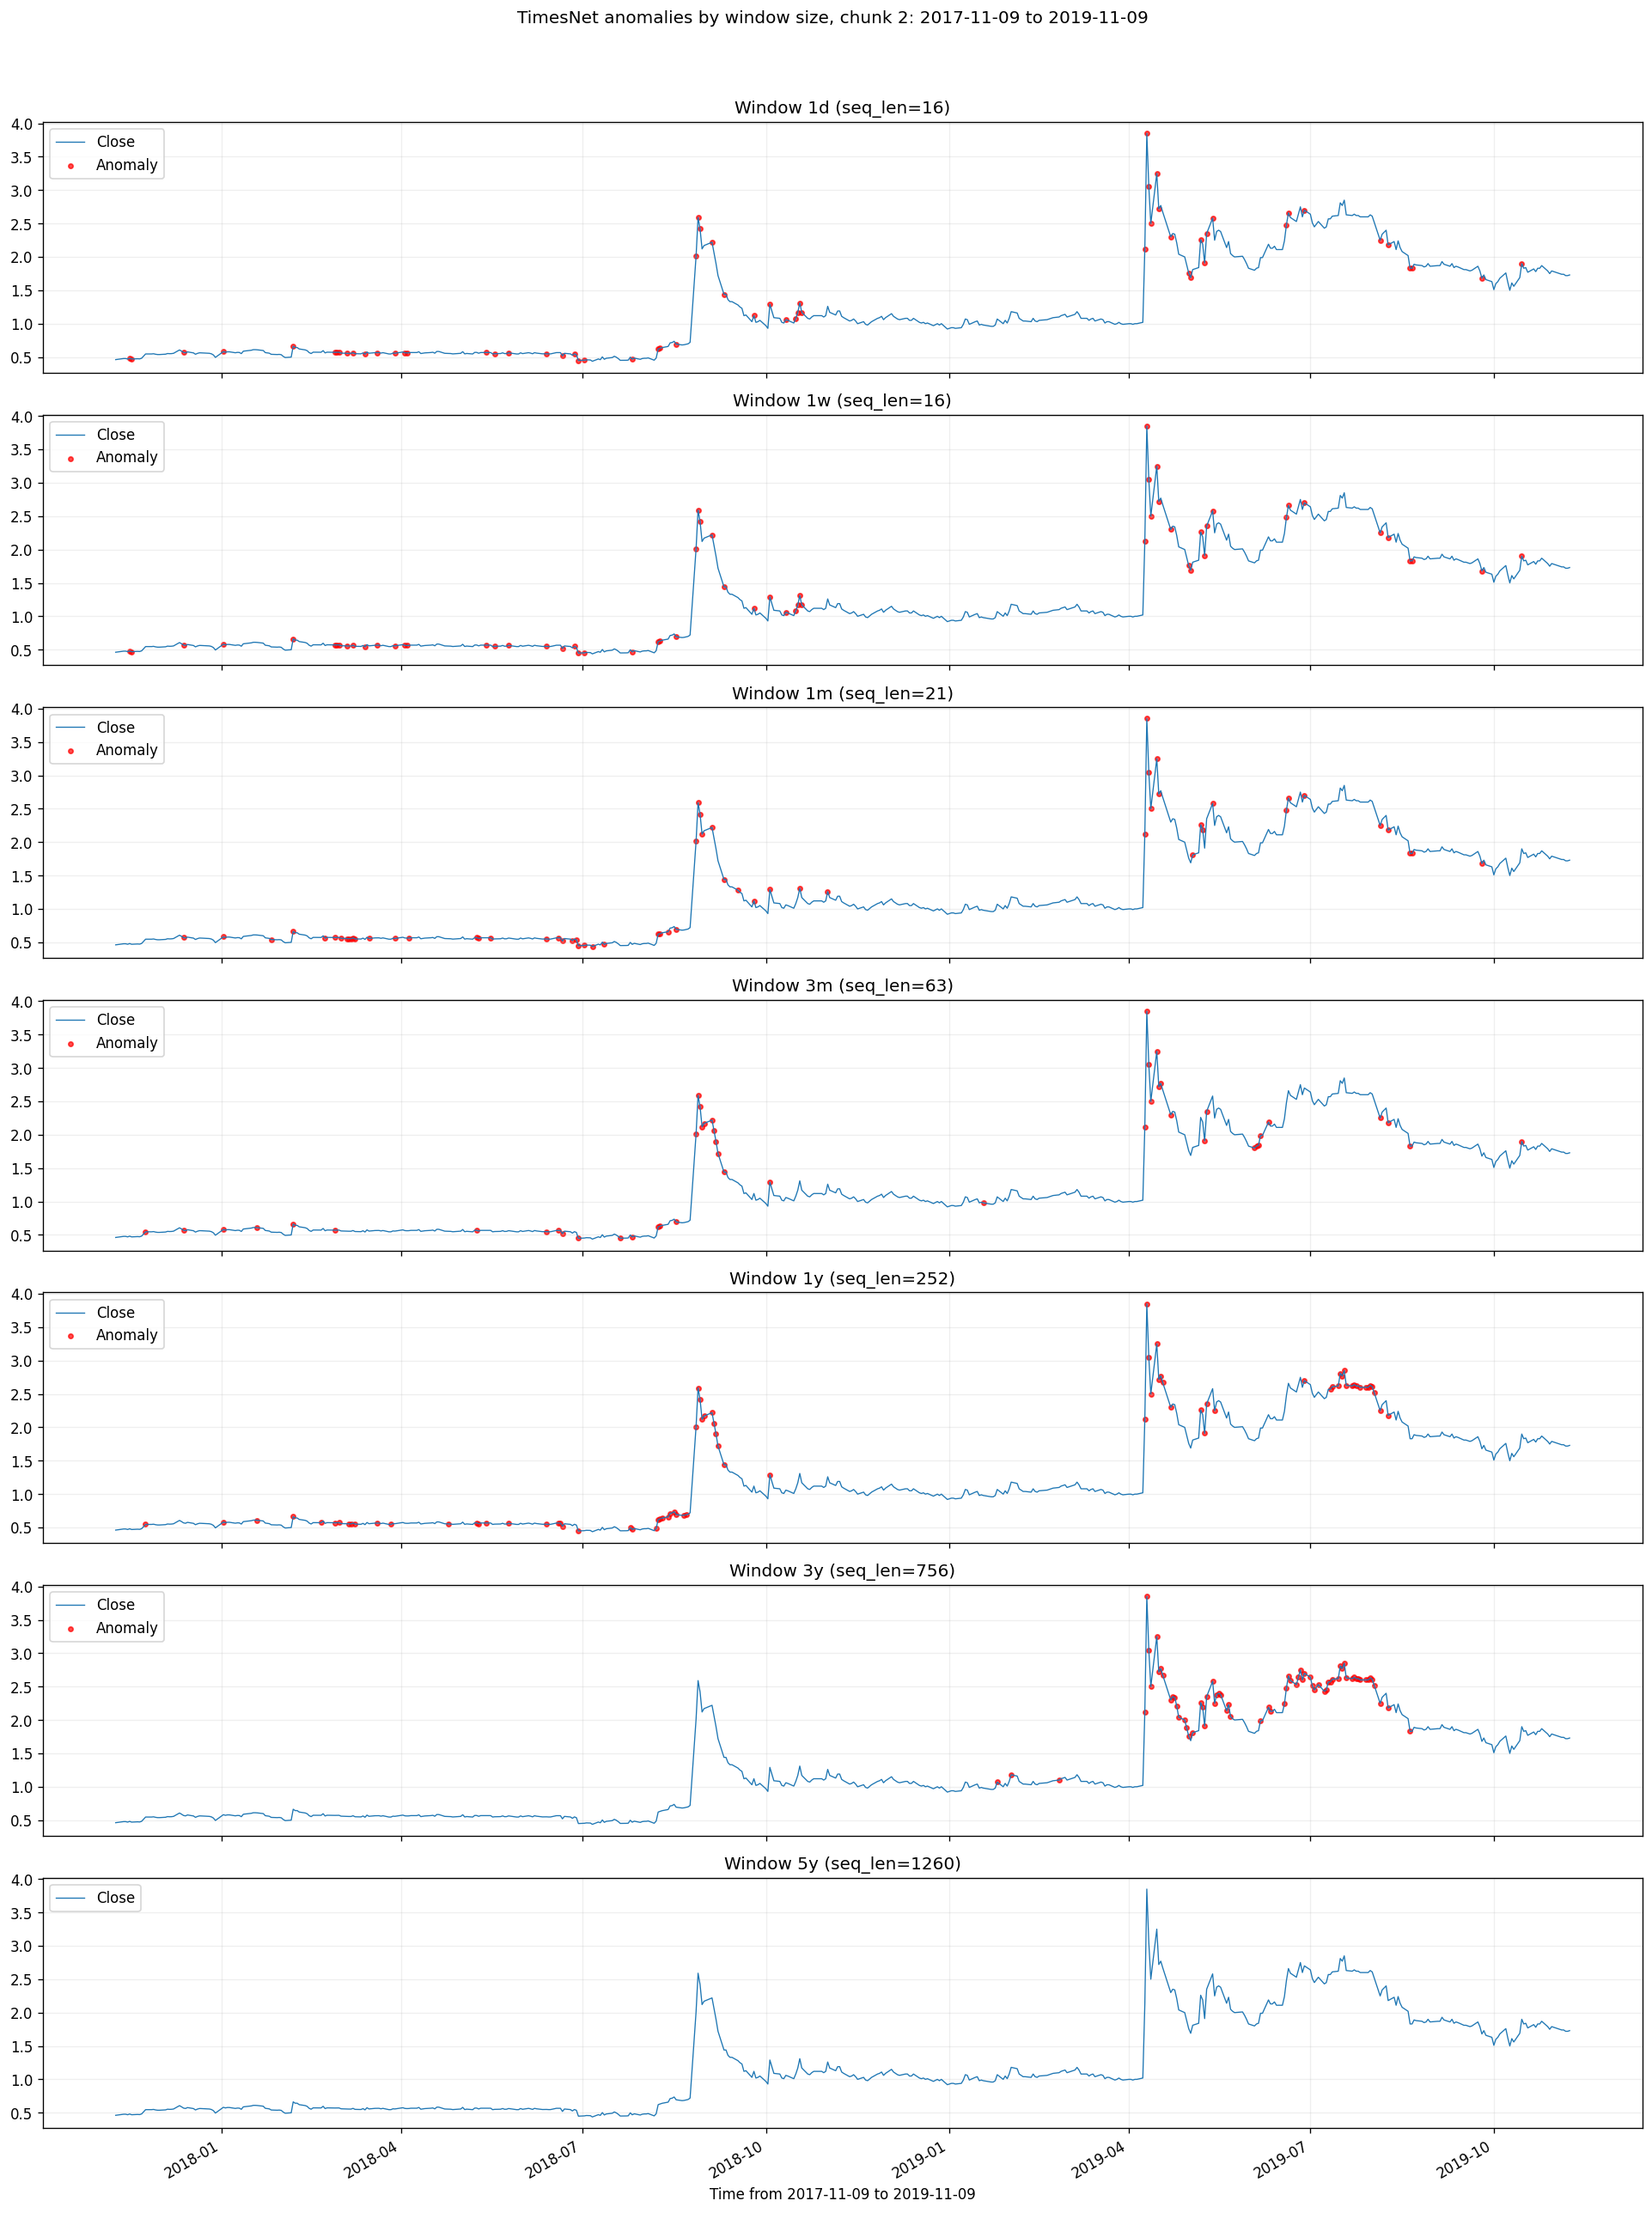

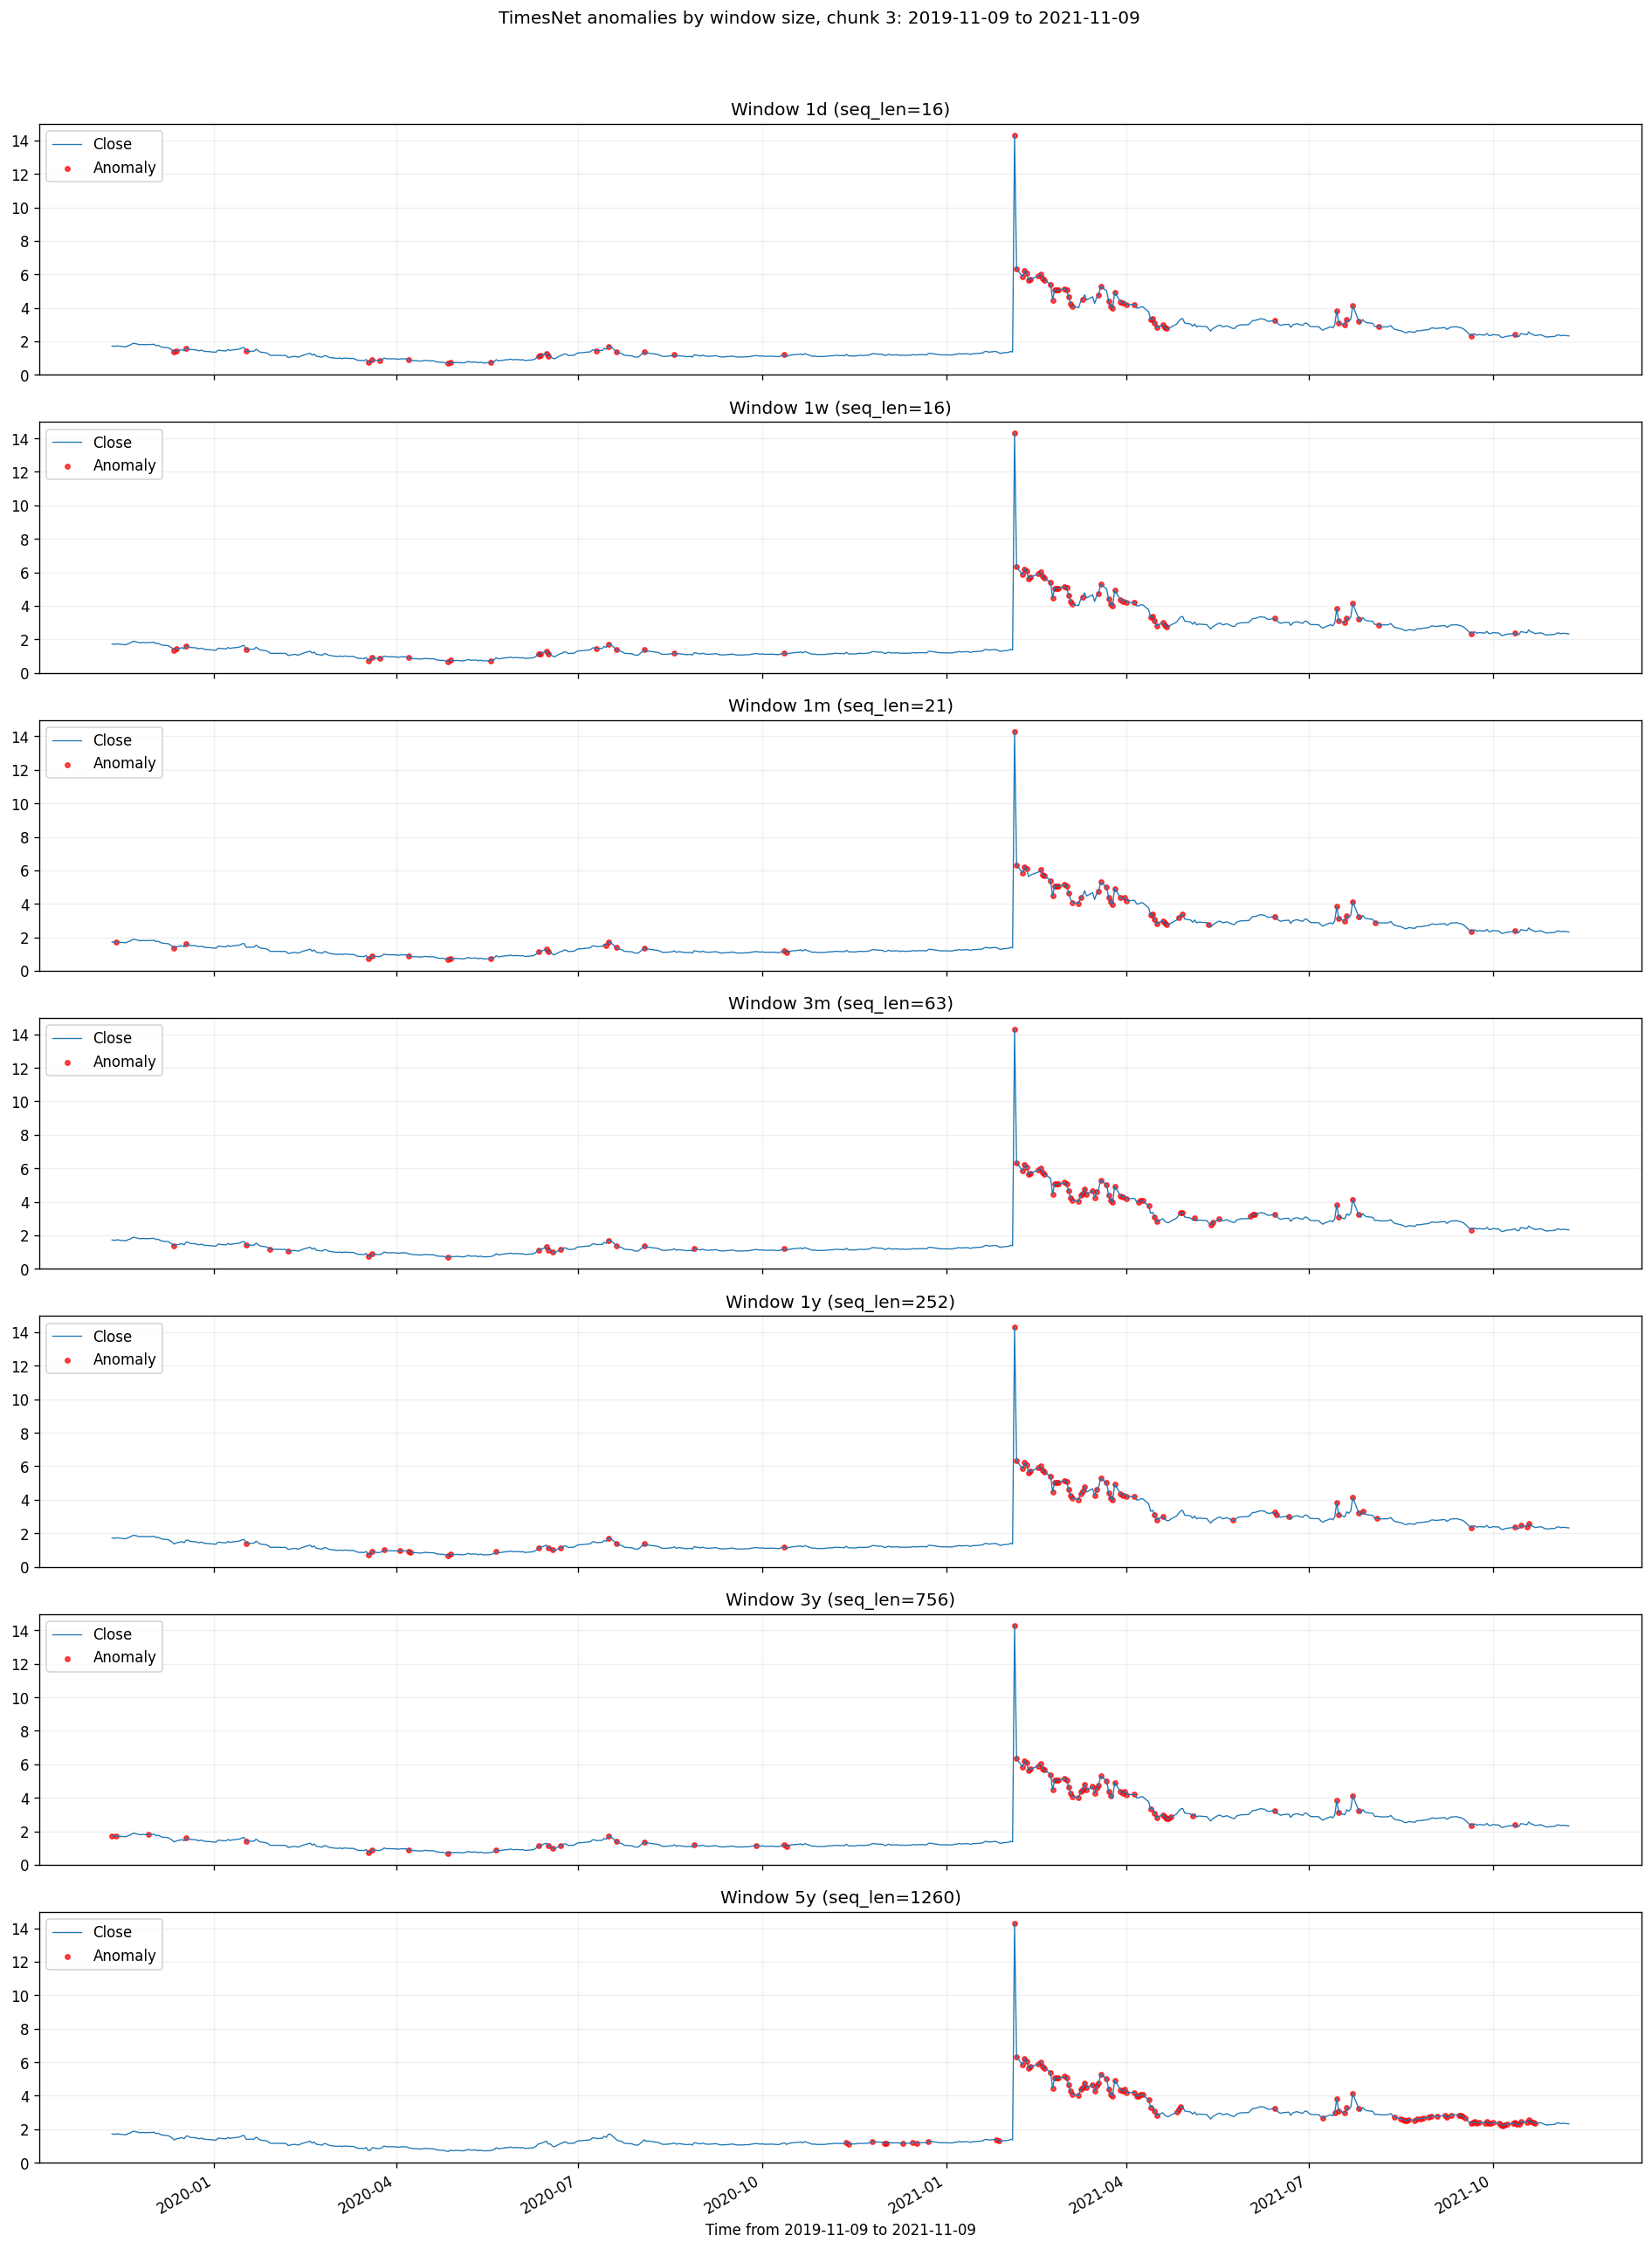

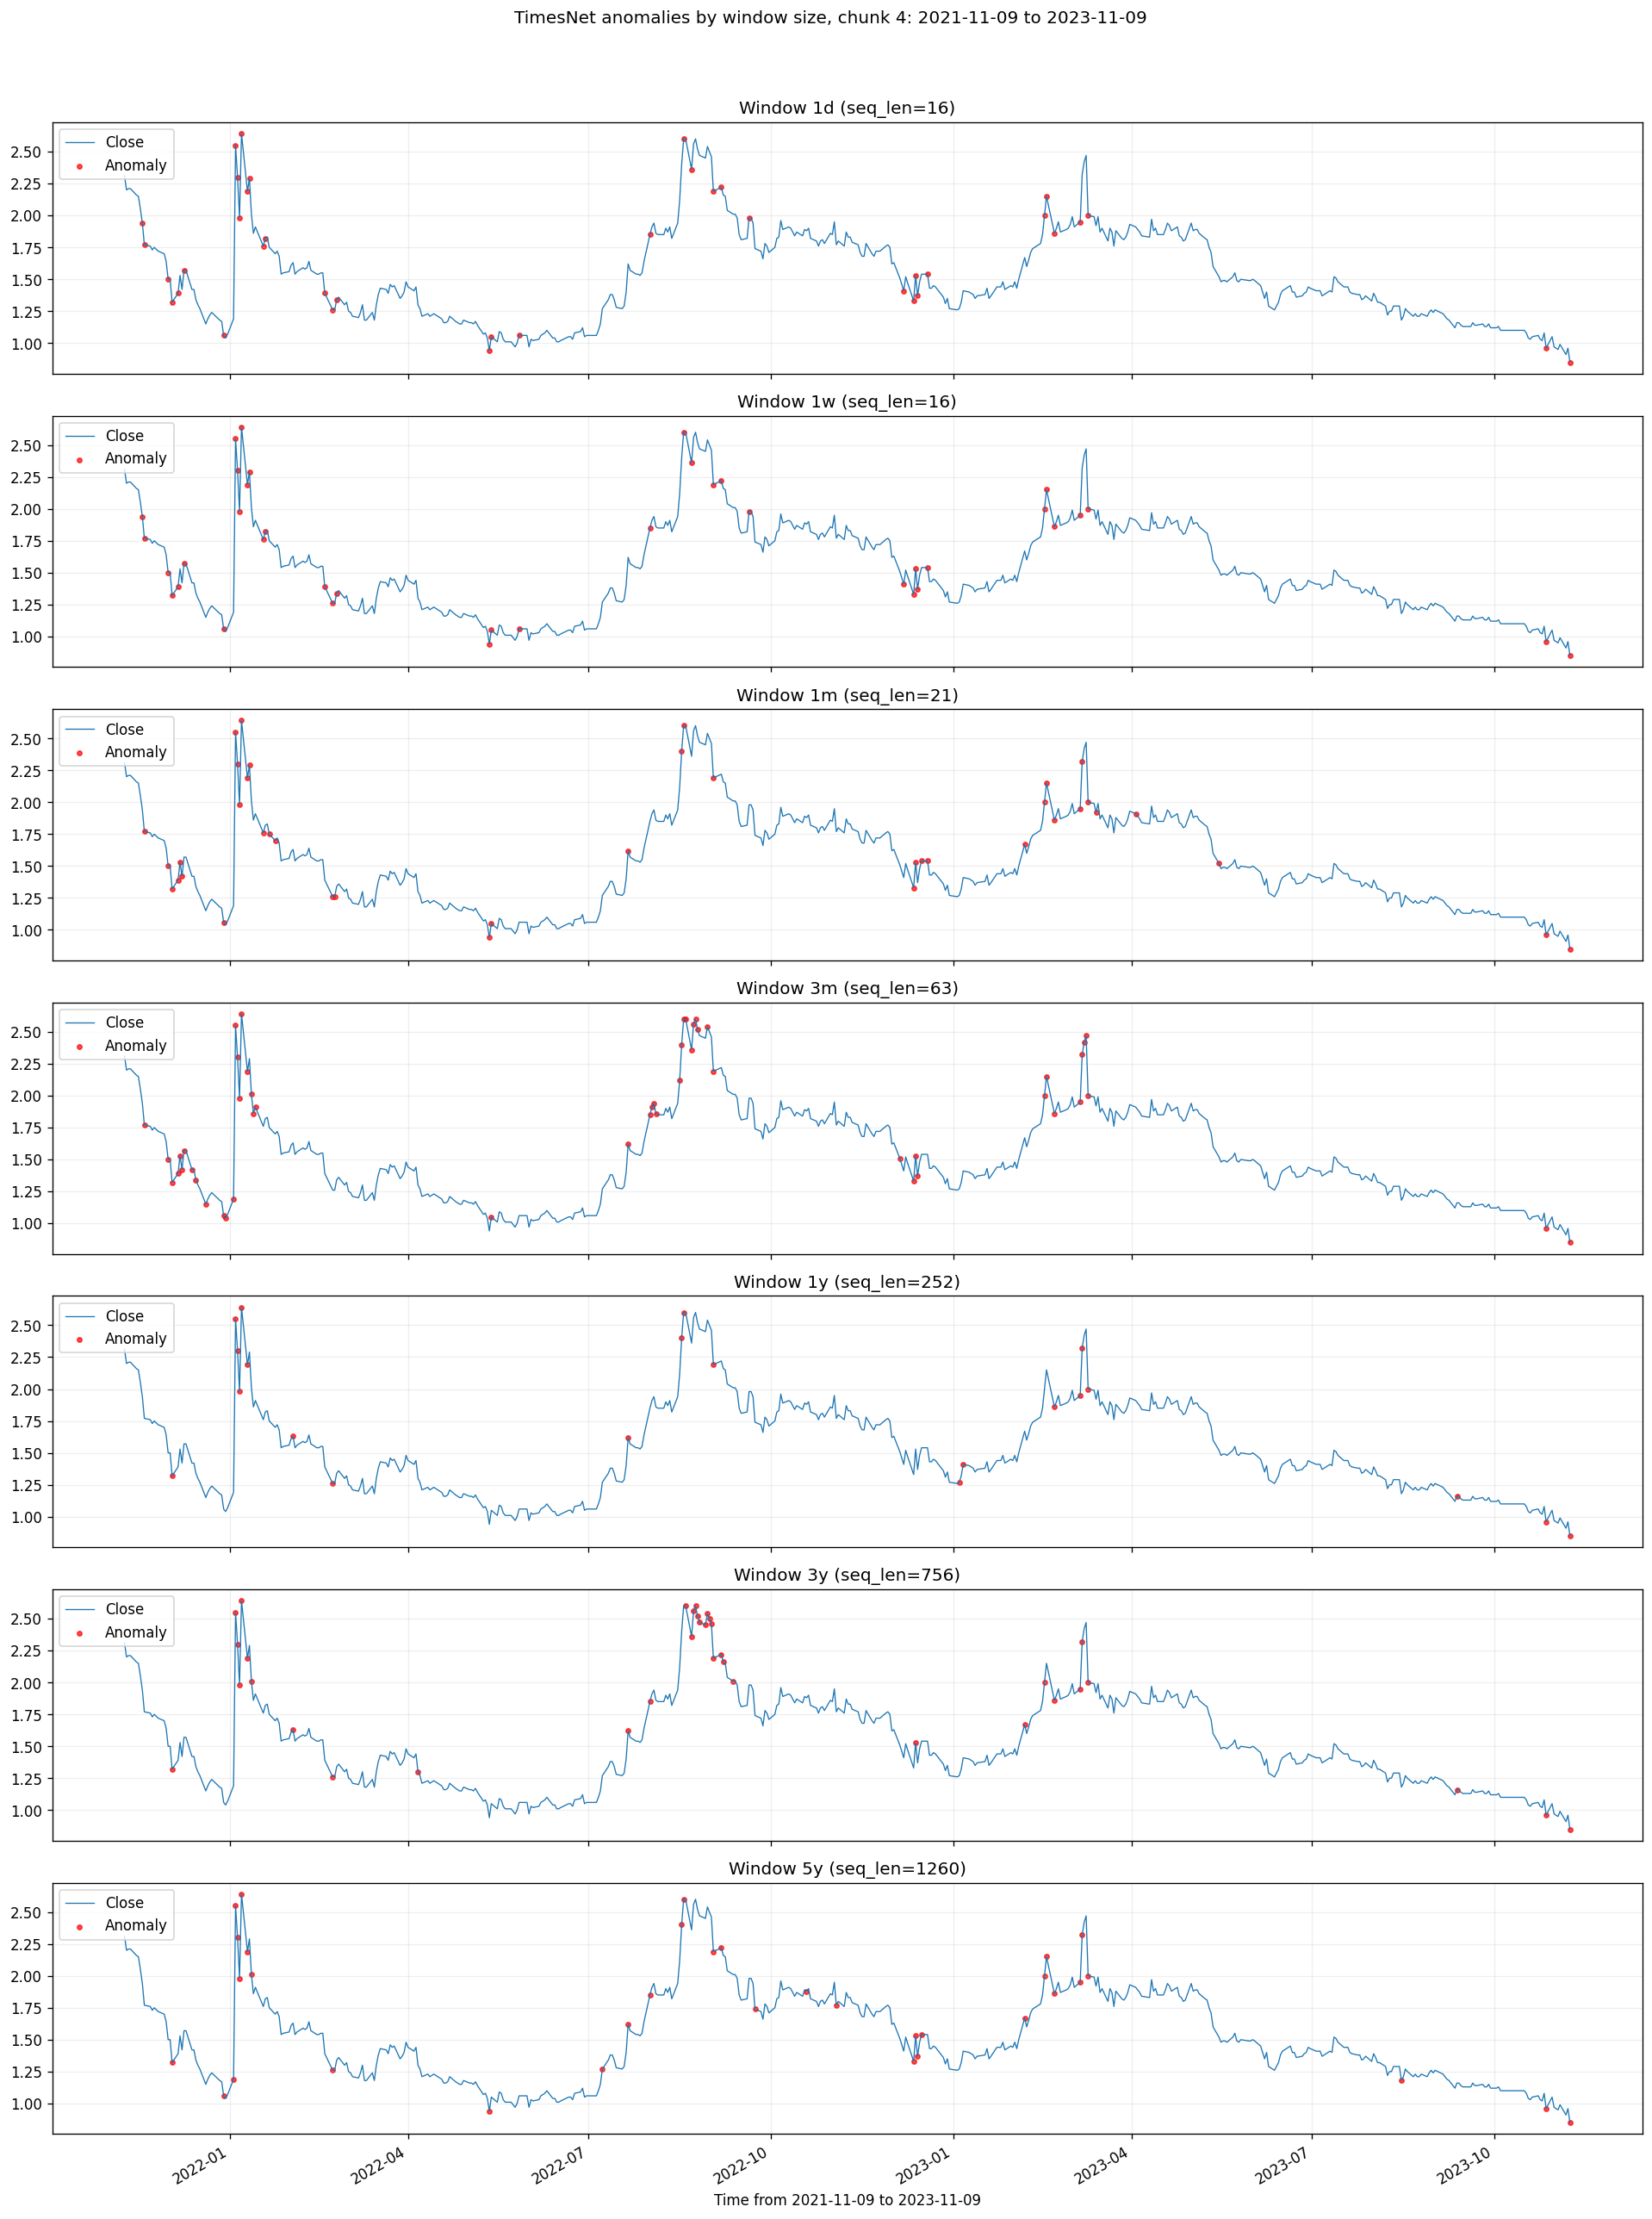

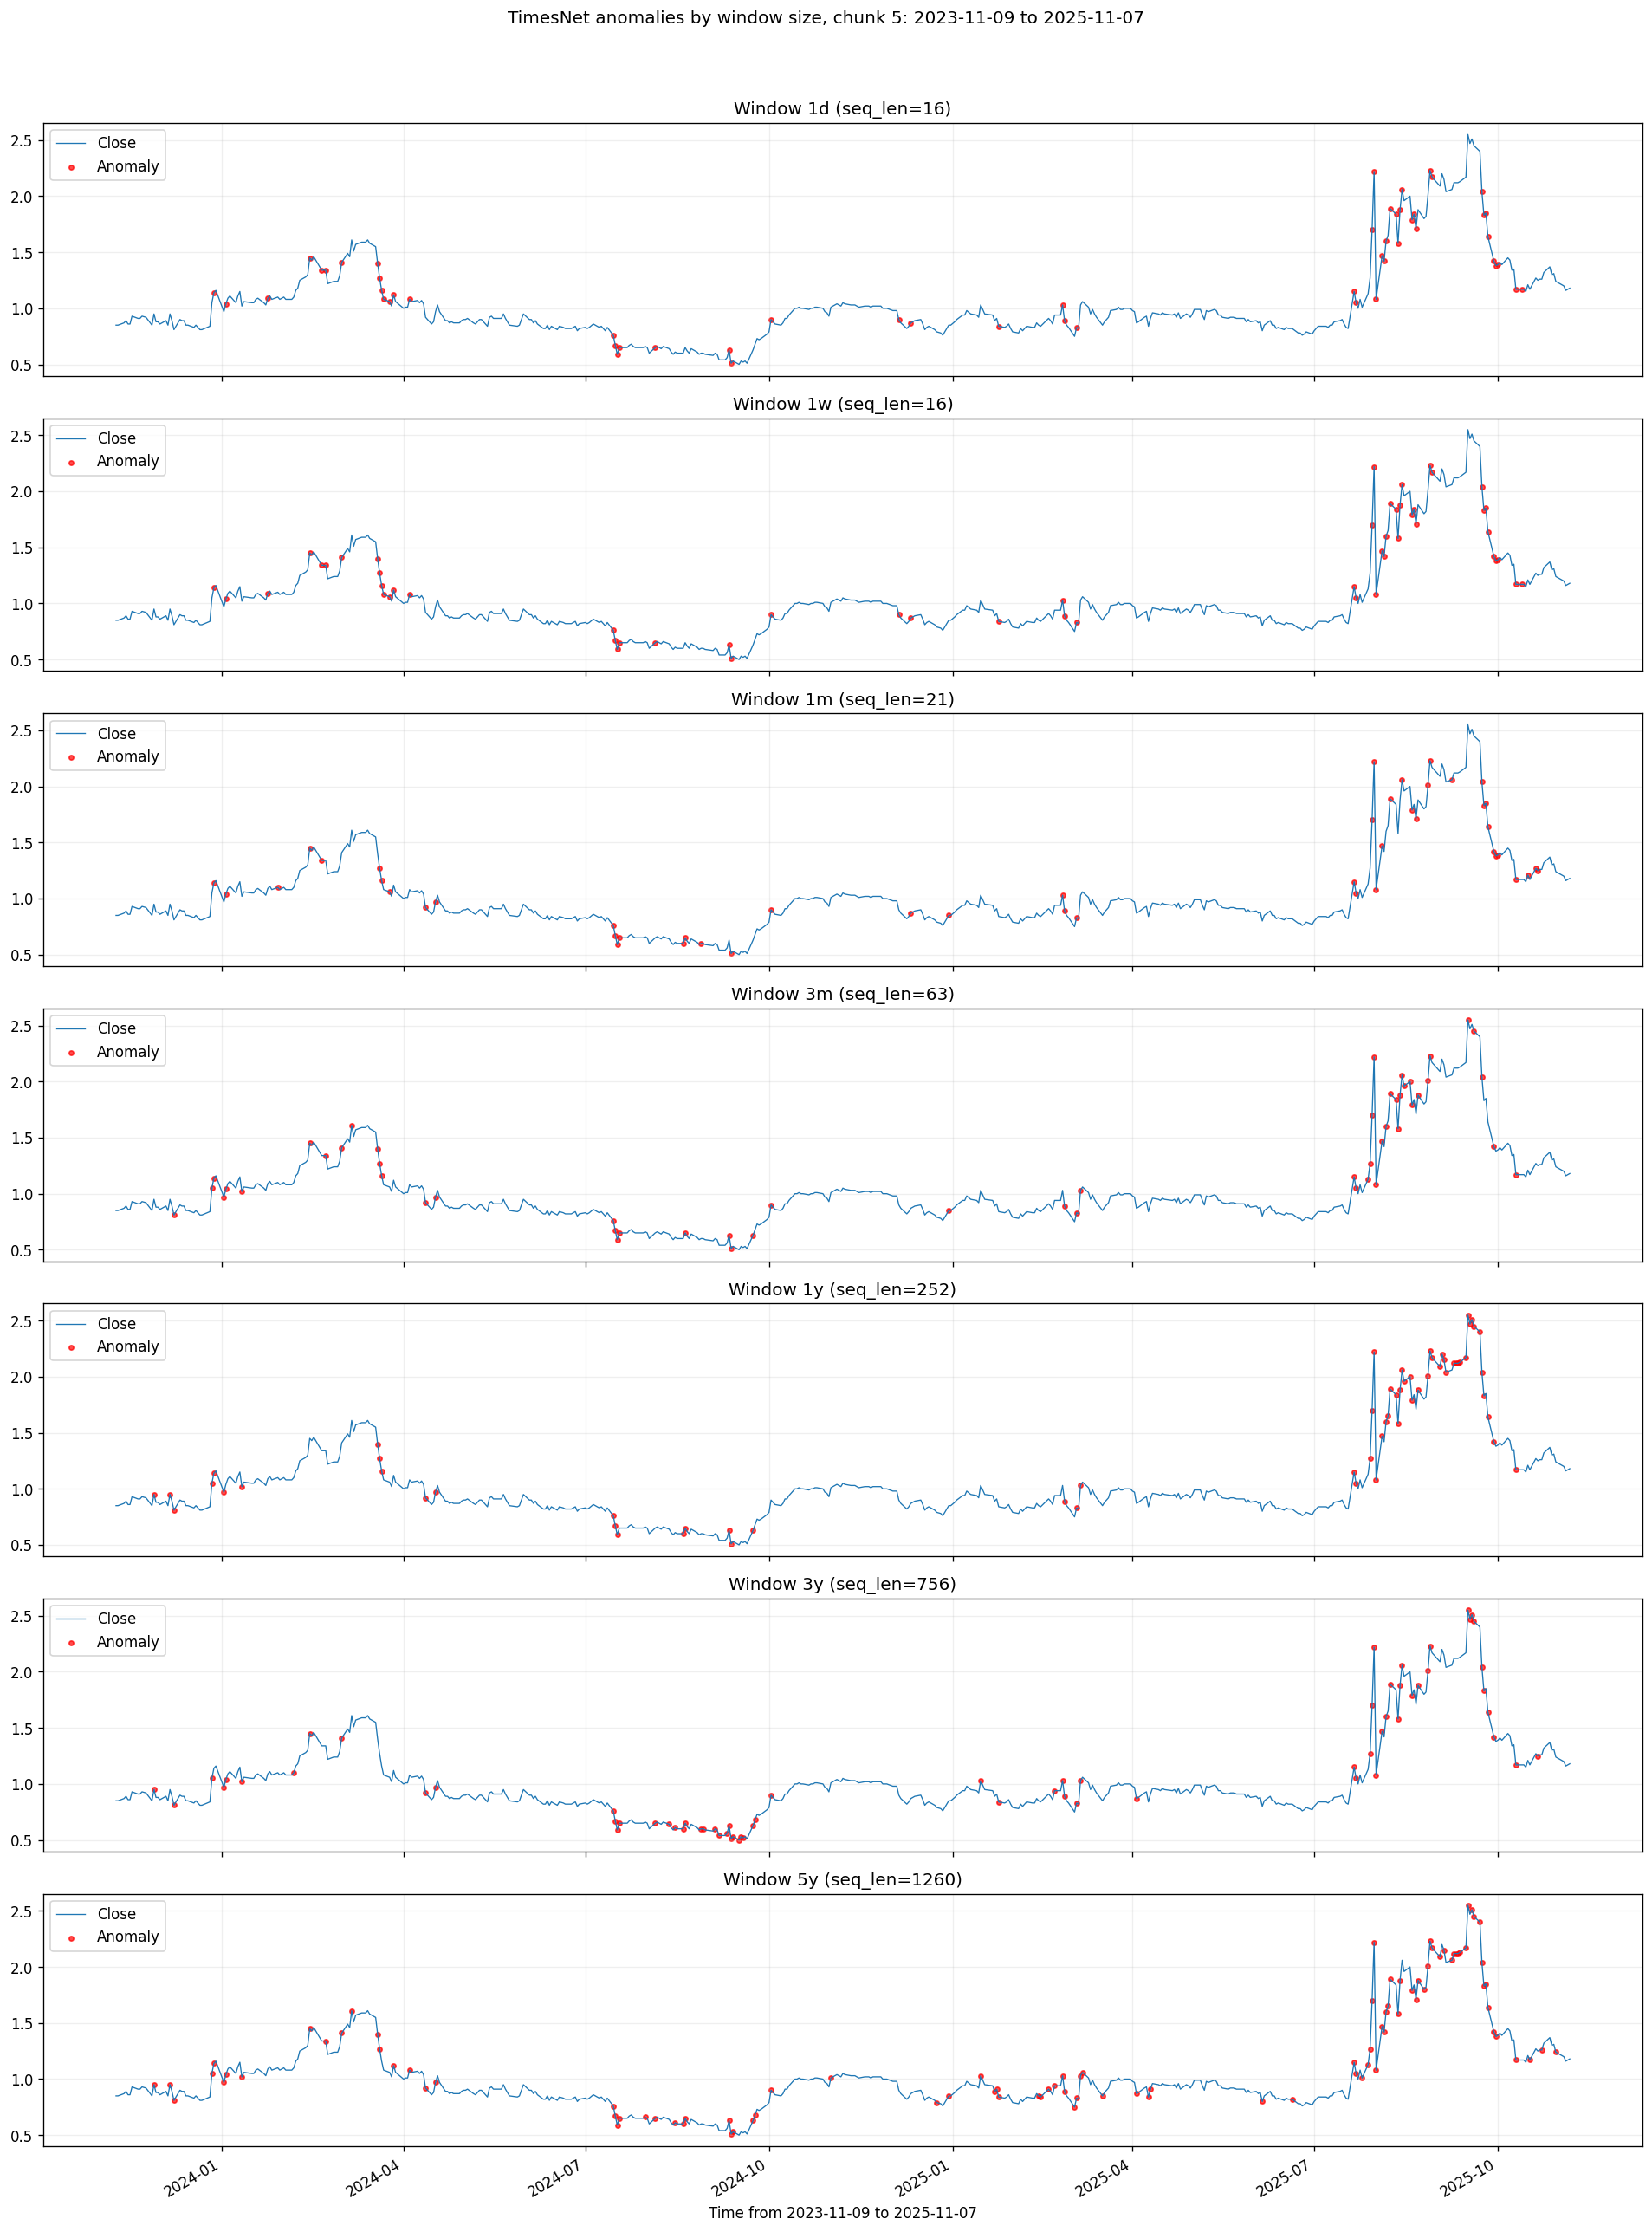

In [12]:
plot_compare_windows_grid(df_results)

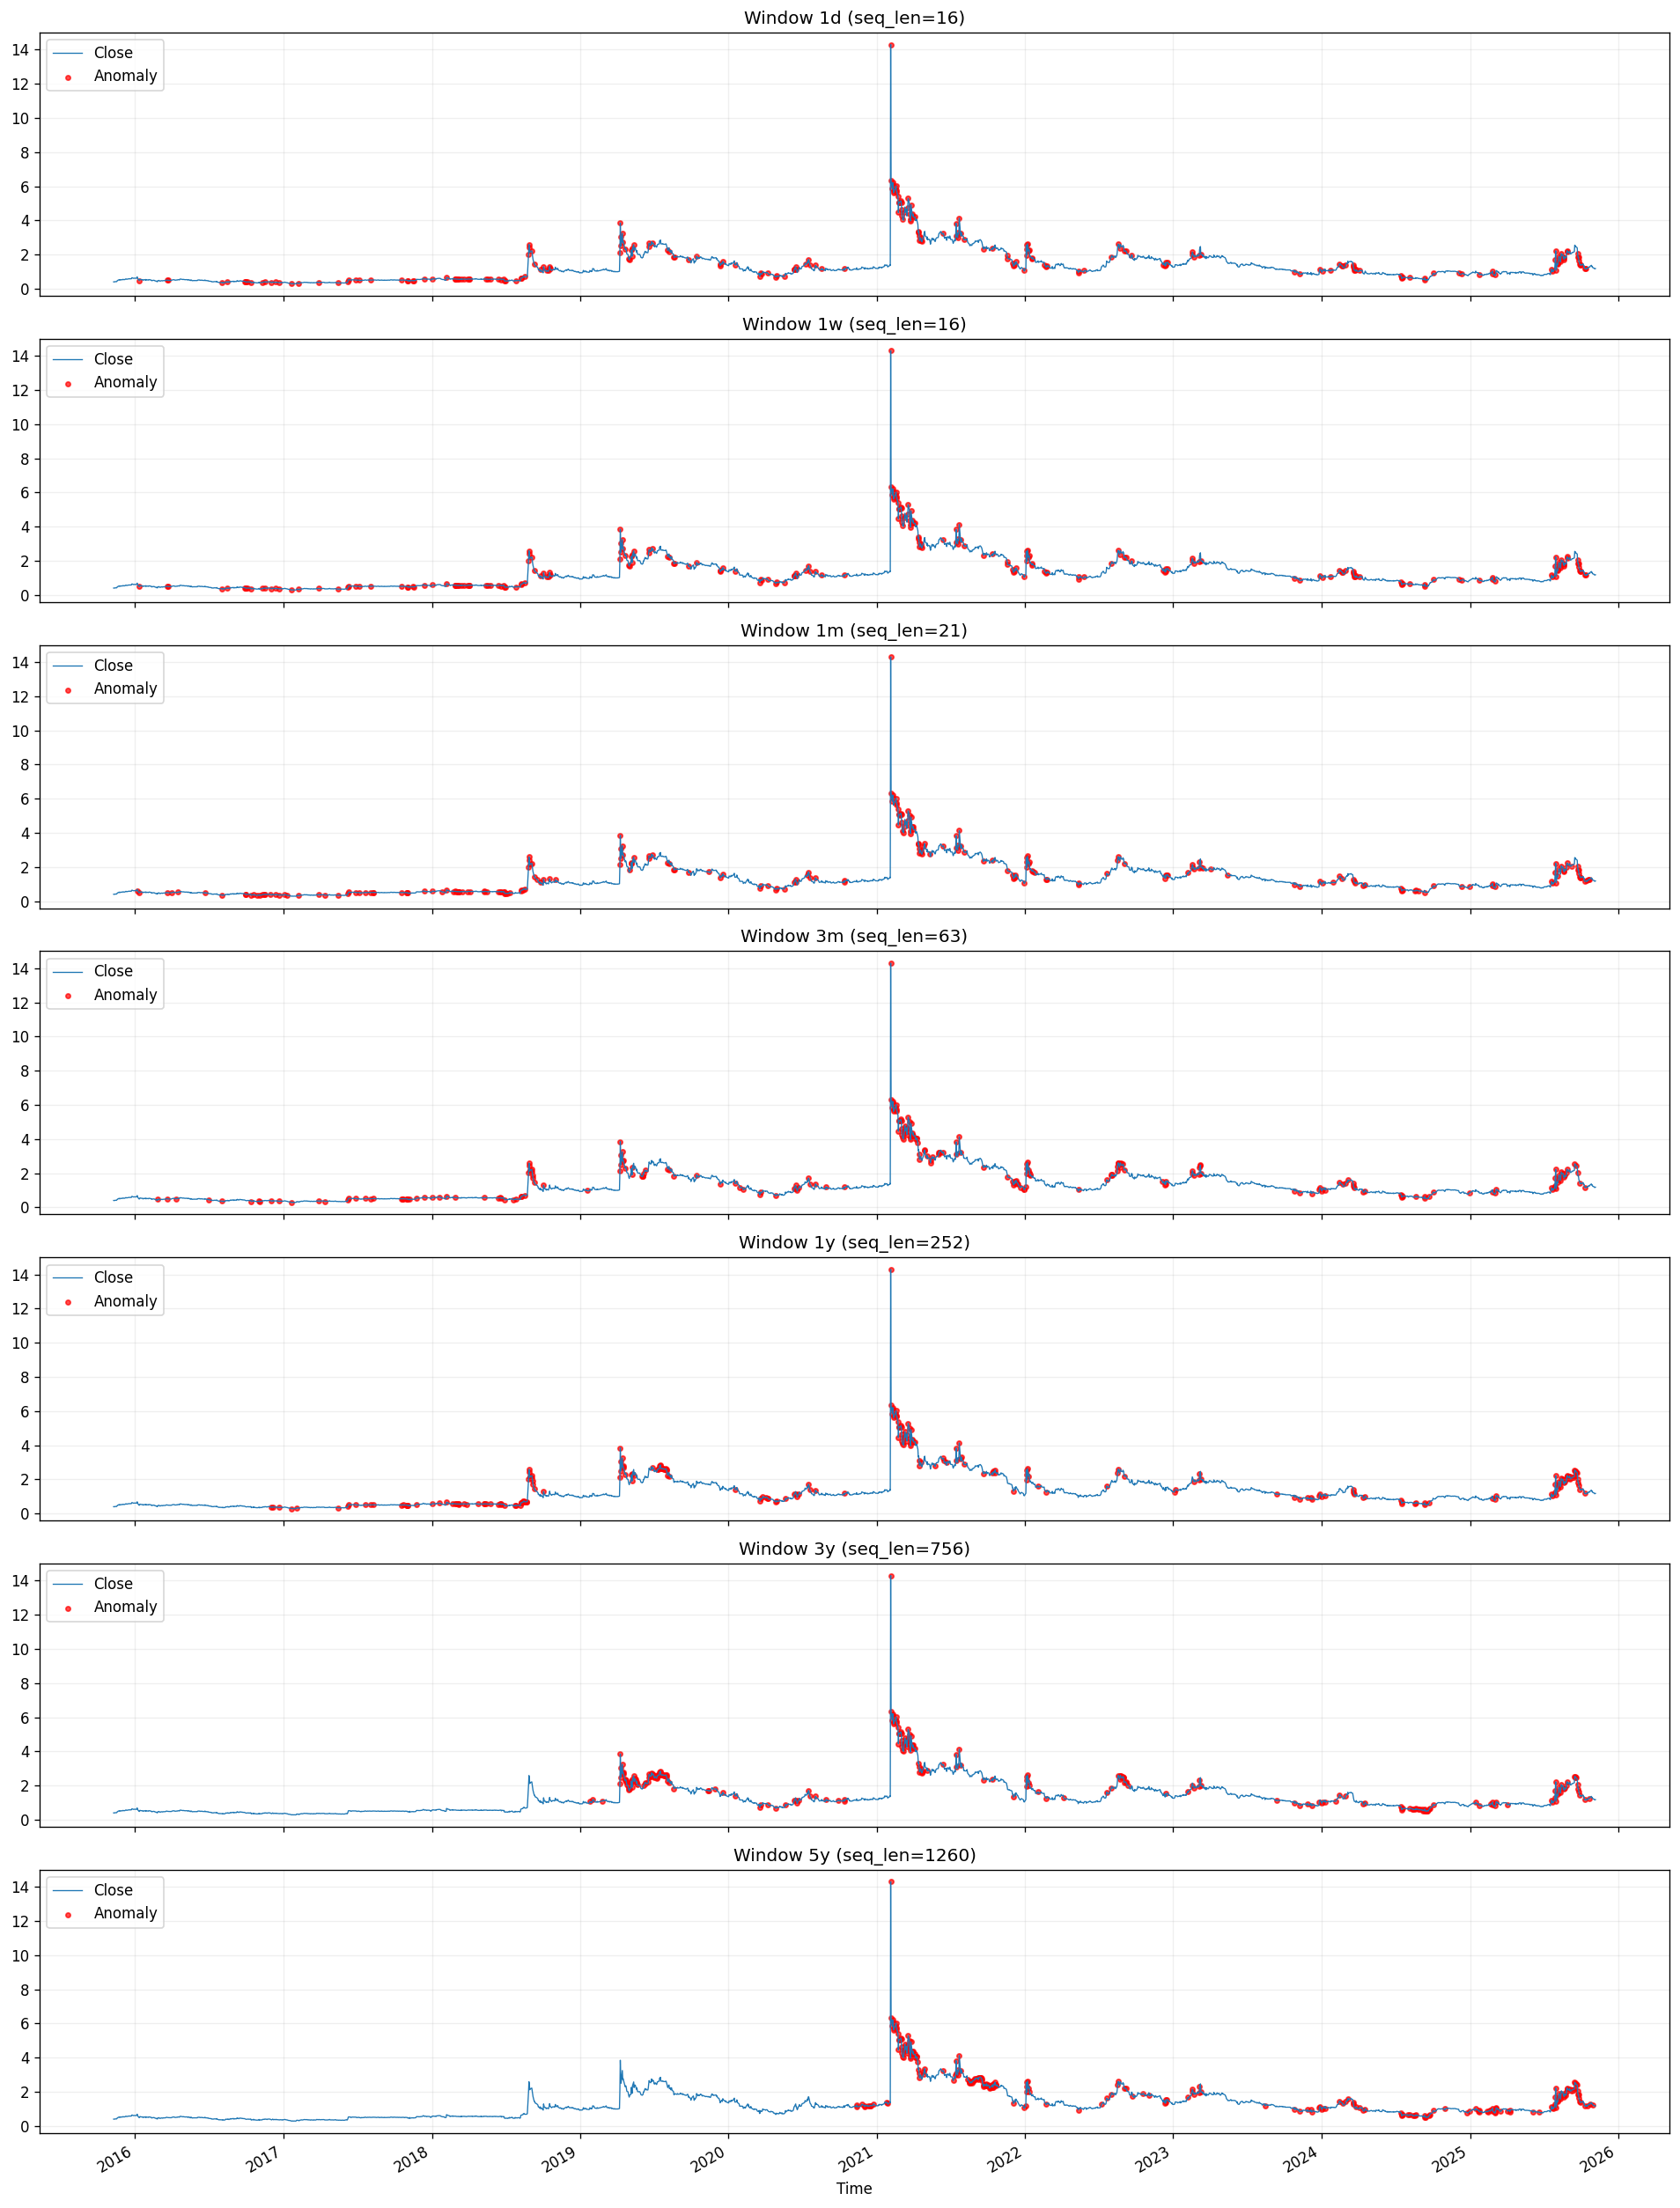

In [13]:
def plot_compare_windows_grid(
    df_results: dict,
    window_order: list = WINDOW_ORDER,
    price_col: str = "Close",
):
    n = len(window_order)
    fig, axes = plt.subplots(
        n,
        1,
        figsize=(16, 3 * n),
        sharex=True,
    )

    if n == 1:
        axes = [axes]

    for ax, name in zip(axes, window_order):
        df = df_results[name]
        label_col = f"label_{name}"

        ax.plot(df.index, df[price_col], linewidth=0.8, label="Close")

        mask_anom = df[label_col] == 1
        ax.scatter(
            df.index[mask_anom],
            df.loc[mask_anom, price_col],
            s=10,
            color="red",
            alpha=0.7,
            label="Anomaly",
        )

        seq_len_used = results[name]["seq_len"]
        ax.set_title(f"Window {name} (seq_len={seq_len_used})")
        ax.grid(alpha=0.2)
        ax.legend(loc="upper left")

    axes[-1].set_xlabel("Time")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


plot_compare_windows_grid(df_results)


In [14]:
summary_rows = []

for name in WINDOW_ORDER:
    res = results[name]
    labels = np.asarray(res["labels"])
    scores = np.asarray(res["scores"])
    summary_rows.append(
        {
            "window": name,
            "seq_len_used": res["seq_len"],
            "n_points": len(labels),
            "n_anomaly": int(labels.sum()),
            "anomaly_ratio": float(labels.mean()),
            "score_mean": float(scores.mean()),
            "score_std": float(scores.std()),
        }
    )

summary_df = pd.DataFrame(summary_rows)
summary_df


window  seq_len_used  n_points  n_anomaly  anomaly_ratio  score_mean  \
0     1d            16      2513        252       0.100279    0.050019   
1     1w            16      2513        252       0.100279    0.050019   
2     1m            21      2513        252       0.100279    0.066182   
3     3m            63      2513        252       0.100279    0.161901   
4     1y           252      2513        252       0.100279    0.196984   
5     3y           756      2513        252       0.100279    0.257090   
6     5y          1260      2513        252       0.100279    0.266149   

   score_std  
0   0.806593  
1   0.806594  
2   1.161199  
3   3.351414  
4   3.702975  
5   4.569944  
6   4.865194